<a href="https://colab.research.google.com/github/arimbawa/Aplikasi-IoT/blob/main/Minggu_4_Database_untuk_IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Materi Minggu 4: Database untuk IoT**

**Tujuan Pembelajaran:**


1.   Mahasiswa memahami integrasi aplikasi IoT dengan database.
2.   Mahasiswa mampu membuat API Flask yang menyimpan dan mengambil data dari database.
3. Mahasiswa dapat menguji alur perangkat → Flask → Database → Visualisasi.

# Langkah Praktikum

1.   Setup Flask Server (Google Colab)

Kita pakai SQLite (ringan, sudah bawaan Python).

In [ ]:
!pip install flask pyngrok sqlalchemy
!pip install paho-mqtt

In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok
import paho.mqtt.client as mqtt
import json
import threading
import sqlite3
from datetime import datetime

# Replace "YOUR_NGROK_AUTH_TOKEN" with your actual ngrok authtoken
ngrok.set_auth_token("xxxxxxxxxxxxx")

# Buat app Flask
app = Flask(__name__)

# Database Setup
DATABASE = 'sensor_data.db'

def init_db():
    with app.app_context():
        db = get_db()
        cursor = db.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS mqtt_readings (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                light REAL,
                timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
            )
        ''')
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS http_readings (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                temperature REAL,
                humidity REAL,
                timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
            )
        ''')
        db.commit()

def get_db():
    db = getattr(g, '_database', None)
    if db is None:
        db = g._database = sqlite3.connect(DATABASE)
    return db

@app.teardown_appcontext
def close_db(error):
    db = getattr(g, '_database', None)
    if db is not None:
        db.close()

from flask import g

# MQTT Settings
MQTT_BROKER = "broker.hivemq.com"
MQTT_PORT = 1883
MQTT_TOPIC = "unram/iot/sensor"

# MQTT Callbacks
def on_connect(client, userdata, flags, rc):
    if rc == 0:
        print("Connected to MQTT Broker!")
        client.subscribe(MQTT_TOPIC)
        print(f"Subscribed to topic: {MQTT_TOPIC}")
    else:
        print(f"Failed to connect, return code {rc}\n")

def on_message(client, userdata, msg):
    print(f"Received `{msg.payload.decode()}` from `{msg.topic}` topic")
    try:
        data = json.loads(msg.payload.decode())
        # Assuming the MQTT message contains 'light' data
        if 'light' in data:
            light_value = data['light']
            with app.app_context():
                db = get_db()
                cursor = db.cursor()
                cursor.execute("INSERT INTO mqtt_readings (light) VALUES (?)", (light_value,))
                db.commit()
                print("Light data added to mqtt_readings table:", light_value)
        else:
            print("MQTT message does not contain 'light' data.")
    except json.JSONDecodeError:
        print("Failed to decode JSON from MQTT message.")
    except Exception as e:
        print(f"Error inserting MQTT data into database: {e}")


# Create MQTT Client
client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

# Connect to MQTT Broker in a separate thread
def connect_mqtt():
    client.connect(MQTT_BROKER, MQTT_PORT, 60)
    client.loop_forever()

mqtt_thread = threading.Thread(target=connect_mqtt)
mqtt_thread.start()


@app.route('/sensor', methods=['POST'])
def receive_sensor():
    data = request.json
    try:
        if 'temperature' in data and 'humidity' in data:
            temperature_value = data['temperature']
            humidity_value = data['humidity']
            db = get_db()
            cursor = db.cursor()
            cursor.execute("INSERT INTO http_readings (temperature, humidity) VALUES (?, ?)", (temperature_value, humidity_value))
            db.commit()
            print("Received temperature and humidity data via HTTP and added to http_readings table:", data)
            return jsonify({"status": "success", "received": data})
        else:
            print("HTTP data does not contain 'temperature' or 'humidity' data.")
            return jsonify({"status": "error", "message": "No 'temperature' or 'humidity' data in request"}), 400
    except Exception as e:
        print(f"Error inserting HTTP temperature and humidity data into database: {e}")
        return jsonify({"status": "error", "message": str(e)}), 500


@app.route('/data/light', methods=['GET'])
def get_light_data():
    db = get_db()
    cursor = db.cursor()

    cursor.execute("SELECT id, light, timestamp FROM mqtt_readings")
    mqtt_rows = cursor.fetchall()
    mqtt_data = []
    for row in mqtt_rows:
        mqtt_data.append({"id": row[0], "light": row[1], "timestamp": row[2], "source": "mqtt"})

    return jsonify({"mqtt_data": mqtt_data})

@app.route('/data/temp_hum', methods=['GET'])
def get_temp_hum_data():
    db = get_db()
    cursor = db.cursor()
    cursor.execute("SELECT id, temperature, humidity, timestamp FROM http_readings")
    http_rows = cursor.fetchall()
    http_data = []
    for row in http_rows:
        http_data.append({"id": row[0], "temperature": row[1], "humidity": row[2], "timestamp": row[3], "source": "http"})

    return jsonify({"http_data": http_data})

# Initialize the database
init_db()

# Buka tunnel ngrok di port 5000
public_url = ngrok.connect(5000).public_url
print("Flask server URL:", public_url)

# Jalankan Flask
if __name__ == '__main__':
    app.run(port=5000)

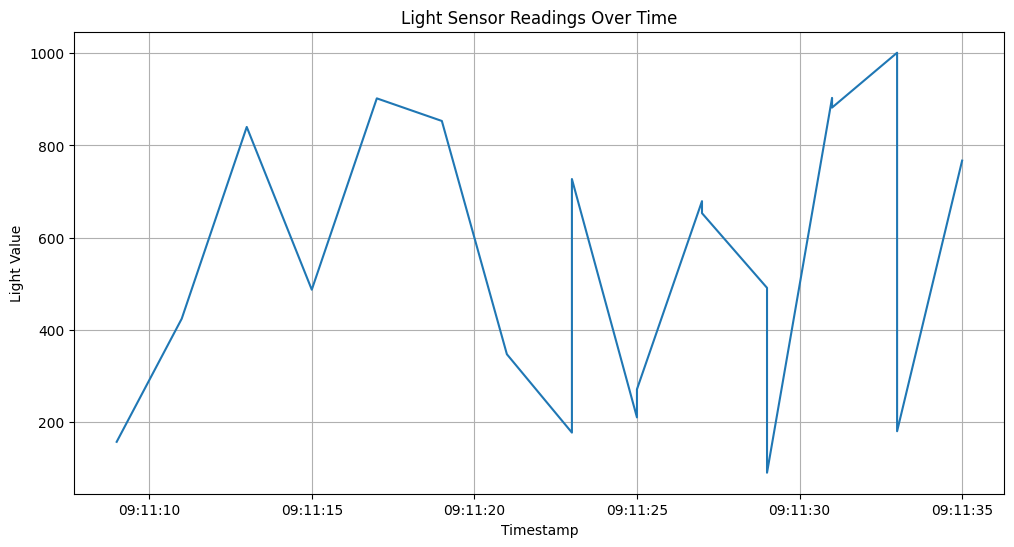

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

DATABASE = 'sensor_data.db'

def get_light_data():
    conn = None
    try:
        conn = sqlite3.connect(DATABASE)
        cursor = conn.cursor()
        cursor.execute("SELECT light, timestamp FROM mqtt_readings ORDER BY timestamp LIMIT 20")
        rows = cursor.fetchall()
        return rows
    except Exception as e:
        print(f"Error retrieving light data: {e}")
        return None
    finally:
        if conn:
            conn.close()

light_data = get_light_data()

if light_data:
    df = pd.DataFrame(light_data, columns=['light', 'timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['light'])
    plt.xlabel("Timestamp")
    plt.ylabel("Light Value")
    plt.title("Light Sensor Readings Over Time")
    plt.grid(True)
    plt.show()
else:
    print("No light data available to plot.")

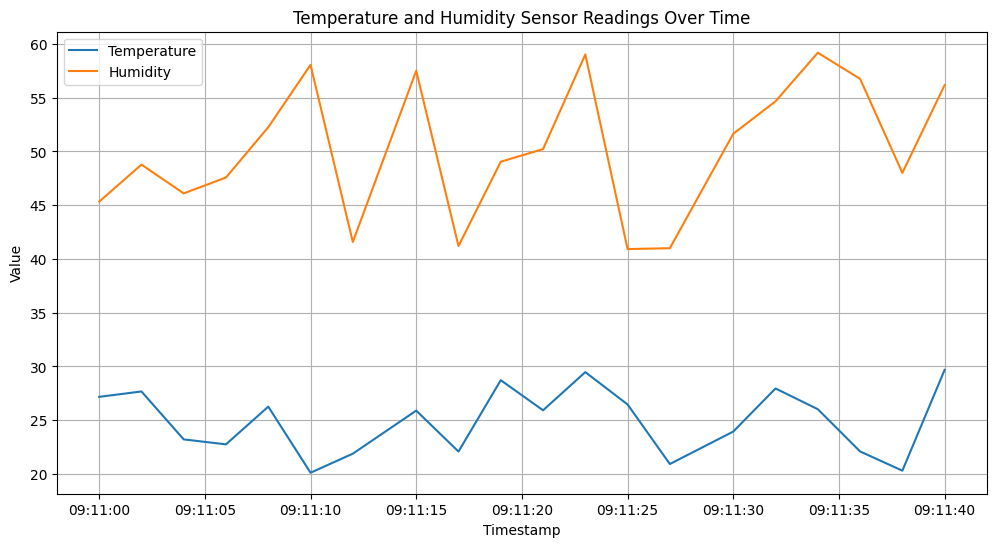

In [ ]:
def get_temp_hum_data():
    conn = None
    try:
        conn = sqlite3.connect(DATABASE)
        cursor = conn.cursor()
        cursor.execute("SELECT temperature, humidity, timestamp FROM http_readings ORDER BY timestamp LIMIT 20")
        rows = cursor.fetchall()
        return rows
    except Exception as e:
        print(f"Error retrieving temperature/humidity data: {e}")
        return None
    finally:
        if conn:
            conn.close()

temp_hum_data = get_temp_hum_data()

if temp_hum_data:
    df_temp_hum = pd.DataFrame(temp_hum_data, columns=['temperature', 'humidity', 'timestamp'])
    df_temp_hum['timestamp'] = pd.to_datetime(df_temp_hum['timestamp'])

    plt.figure(figsize=(12, 6))
    plt.plot(df_temp_hum['timestamp'], df_temp_hum['temperature'], label='Temperature')
    plt.plot(df_temp_hum['timestamp'], df_temp_hum['humidity'], label='Humidity')
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.title("Temperature and Humidity Sensor Readings Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No temperature or humidity data available to plot.")

To use `pyngrok`, you need to get an authtoken from the ngrok dashboard ([https://dashboard.ngrok.com/get-started/your-authtoken](https://dashboard.ngrok.com/get-started/your-authtoken)). Once you have it, you can add it to the code using `ngrok.set_auth_token()`.

Setelah dijalankan, akan muncul URL publik https://xxxxx.ngrok.io → endpoint ini akan dipakai oleh client (HTTP/MQTT).

# Output yang Diharapkan

1. Data sensor berhasil disimpan di SQLite melalui Flask.

2. Endpoint /data menampilkan list JSON data sensor.

3. Mahasiswa memahami bagaimana server IoT menyimpan data sensor untuk analisis lebih lanjut.